# Introduction

In this assignment you will be given a series of tasks about using the library `power-grid-model` and performing a
**state estimation**. In this assignment we will use the output data of a power flow calculation as input for our sensors
so we can perform a state estimation. The tasks include:

* Think about the number of sensors needed
* Print the required loadflow output
* Initializing only the required sensors and performing a state estimation
* Comparing the state estimation results to the loadflow output
* Adding more sensors to make the calculation more accurate

The network we'll be using for troughout this workshop consists of three nodes, two lines, two loads and a source as shown below:

```
 node_1 ---<line_4>--- node_2 ---<line_5>--- node_3
   |                     |                     |
source_8               load_6                load_7
```

# Preparation

First import everything we need for this workshop:

In [1]:
from typing import Dict

import numpy as np
import pandas as pd

from IPython.display import display, Markdown

from power_grid_model import (
    PowerGridModel,
    CalculationType,
    CalculationMethod,
    ComponentType,
    DatasetType,
    LoadGenType,
    initialize_array,
    
)

from power_grid_model.validation import (
    assert_valid_input_data,
    assert_valid_batch_data
)

## Generate example data

In order to use realistic data in out workshop, we use the results of a power flow calculation, which gives us voltages, voltage angles, active powers, reactive powers, etc. Below all components of the network are initialized, a model is composed and a power flow calculation is executed.

In [2]:
# Initialize 3 nodes
node = initialize_array(DatasetType.input, ComponentType.node, 3)
node["id"] = [1, 2, 3]
node["u_rated"] = [10.5e3, 10.5e3, 10.5e3]

# Initialize 2 lines between the 3 nodes
line = initialize_array(DatasetType.input, ComponentType.line, 2)
line["id"] = [4, 5]
line["from_node"] = [1, 2]
line["to_node"] = [2, 3]
line["from_status"] = [1, 1]
line["to_status"] = [1, 1]
line["r1"] = [0.25, 0.25]
line["x1"] = [0.2, 0.2]
line["c1"] = [10e-6, 10e-6]
line["tan1"] = [0.0, 0.0]
line["i_n"] = [1000, 1000]

# Initialize 2 loads, each connected to a different node
sym_load = initialize_array(DatasetType.input, ComponentType.sym_load, 2)
sym_load["id"] = [6, 7]
sym_load["node"] = [2, 3]
sym_load["status"] = [1, 1]
sym_load["type"] = [LoadGenType.const_power, LoadGenType.const_power]
sym_load["p_specified"] = [20e6, 10e6]
sym_load["q_specified"] = [5e6, 2e6]

# Initialize 1 source, connected to a different node than the loads
source = initialize_array(DatasetType.input, ComponentType.source, 1)
source["id"] = [8]
source["node"] = [1]
source["status"] = [1]
source["u_ref"] = [1.0]

# Construct the input data
input_data = {
    ComponentType.node: node,
    ComponentType.line: line,
    ComponentType.sym_load: sym_load,
    ComponentType.source: source
}

# Validate the input data
assert_valid_input_data(input_data)

# Create a power grid model
model = PowerGridModel(input_data)

# Run a (Newton Raphson) power flow calculation
pf_output_data = model.calculate_power_flow(
    symmetric=True, 
    error_tolerance=1e-8, 
    max_iterations=20, 
    calculation_method=CalculationMethod.newton_raphson
)

### View example data

In [3]:
# Display the results
for component, data in pf_output_data.items():
    display(Markdown(f"### {component.title()}s (power flow):"))
    display(pd.DataFrame(data))

### Nodes (power flow):

,id,energized,u_pu,u,u_angle,p,q
0,1,1,0.998793,10487.324420,-0.003196,3.295415e+07,8.770876e+06
1,2,1,0.908594,9540.234227,-0.046736,-2.000000e+07,-5.000000e+06
2,3,1,0.878800,9227.404378,-0.064156,-1.000000e+07,-2.000000e+06


### Lines (power flow):

,id,energized,loading,p_from,q_from,i_from,s_from,p_to,q_to,i_to,s_to
0,4,1,1.881744,3.295415e+07,8.770876e+06,1877.356010,3.410138e+07,-3.030384e+07,-6.966361e+06,1881.744187,3.109426e+07
1,5,1,0.638082,1.030384e+07,1.966361e+06,634.815121,1.048979e+07,-1.000000e+07,-2.000000e+06,638.081993,1.019804e+07


### Sym_Loads (power flow):

,id,energized,p,q,i,s,pf
0,6,1,20000000.0,5000000.0,1247.598375,2.061553e+07,0.970143
1,7,1,10000000.0,2000000.0,638.081993,1.019804e+07,0.980581


### Sources (power flow):

,id,energized,p,q,i,s,pf
0,8,1,3.295415e+07,8.770876e+06,1877.35601,3.410138e+07,0.966358


# Assignment 1: Number of sensors

In order to perform a state estimation some voltage and power sensors need to be added to the model.
For the calculation to be successful a minimum number of sensors is required.

- What is the minimum number of sensors to perform a state estimation on the given network?
- How many of those should be voltage sensors?


In [4]:
# Fill in the minimal required number of sensors below
n_sensors = 6         # There are three nodes, so 6 unknowns (3 * voltage + 3 * voltage angle)
n_voltage_sensors = 1 # You always need at least 1 voltage sensor

# Assignment 2: Collecting voltage sensor data

In this assignment print the output of the assets in the the loadflow calculation, which is needed as input for the voltage sensors. 

Hint: convert to a pandas DataFrame before printing for a better overview

In [5]:
# Print the assets in the output data that we need for the voltage sensors
display(pd.DataFrame(pf_output_data[ComponentType.node]))

,id,energized,u_pu,u,u_angle,p,q
0,1,1,0.998793,10487.324420,-0.003196,3.295415e+07,8.770876e+06
1,2,1,0.908594,9540.234227,-0.046736,-2.000000e+07,-5.000000e+06
2,3,1,0.878800,9227.404378,-0.064156,-1.000000e+07,-2.000000e+06


# Assignment 3: Initialize the sensors

In this assignment we will perform a state estimation based on three voltage sensors that only measure the voltage. 
If you look closely to the data, you'll notice that the number of measurements (3) is not larger than or equal to the number of unknowns (6). 
So the system is not *fully observable* and you might expect the state estimation to fail. 
However, the linear state estimation algorithm will assume the voltage angles (3) to be zero if no value is given. 
In other words, the mathematical core will give us a faulty result, without any warning! 
To prevent this, we need an observability check, which is complex, but will be added to the validation functions in the future.

- initialize the voltage sensors
- extend the input data set, with the voltage sensors
- construct a new model with the new input data
- run the state estimation calculation

In [6]:
# Initialize 3 symmetric voltage sensors, each connected to a different node
sym_voltage_sensor = initialize_array(DatasetType.input, ComponentType.sym_voltage_sensor, 3)
sym_voltage_sensor["id"] = [9, 10, 11]
sym_voltage_sensor["measured_object"] = [1, 2, 3]
sym_voltage_sensor["u_sigma"] = 10.0
sym_voltage_sensor["u_measured"] = [10487.324420, 9540.234227, 9227.404378]

# Add the sensors to the input data
input_data[ComponentType.sym_voltage_sensor] = sym_voltage_sensor

# Validate the input data
assert_valid_input_data(input_data, calculation_type=CalculationType.state_estimation, symmetric=True)

# Create a power grid model
model = PowerGridModel(input_data)

# Run the (iterative linear) state estimation
se_output_data = model.calculate_state_estimation(
    symmetric=True, 
    error_tolerance=1e-8, 
    max_iterations=20, 
    calculation_method=CalculationMethod.iterative_linear)

# Assignment 4: Compare the results between the loadflow and state estimation

For all nodes:
- print the difference in `u` between `se_output_data` and `pf_output_data`

For all lines:
- print the difference in `p_from` between `se_output_data` and `pf_output_data`
- print the difference in `p_to` between `se_output_data` and `pf_output_data`
- print the difference in `q_from` between `se_output_data` and `pf_output_data`
- print the difference in `q_to` between `se_output_data` and `pf_output_data`

You should see that while the voltages match quite precisely (in the order of microvolts), the *p* and *q* are way off (in the order of megawatts / mega VARs). This is as expected, because we used voltage angles of 0.0.

In [7]:
# Print the delta u for all nodes (pf_output_data - se_output_data)
print("-------------- nodes --------------")
print("delta_u:", se_output_data[ComponentType.node]["u"] - pf_output_data[ComponentType.node]["u"])

# Print the delta p and q for all lines (pf_output_data - se_output_data)
print("-------------- lines --------------")
print("delta_p_from:", se_output_data[ComponentType.line]["p_from"] - pf_output_data[ComponentType.line]["p_from"])
print("delta_p_to:", se_output_data[ComponentType.line]["p_to"] - pf_output_data[ComponentType.line]["p_to"])
print("delta_q_from:", se_output_data[ComponentType.line]["q_from"] - pf_output_data[ComponentType.line]["q_from"])
print("delta_q_to:", se_output_data[ComponentType.line]["q_to"] - pf_output_data[ComponentType.line]["q_to"])

-------------- nodes --------------
delta_u: [-4.95101631e-07  4.55753252e-07 -3.82213329e-07]
-------------- lines --------------
delta_p_from: [-8728680.30456089 -3024647.99628876]
delta_p_to: [8266130.33127038 2959493.85797146]
delta_q_from: [10436736.61039324  3714027.04294619]
delta_q_to: [-10806776.58902305  -3766150.35360264]


#  Assignment 5: Add voltage angle measurements

Now we will update the model by adding voltage angles to the voltage sensors.
We could alter the `input_data` and construct a new Model, but for the purpose of this workshop (and efficiency) we'll supply the voltage angles as `update_data`, which could potentially be a *batch* calculation in other usecases.

- initialize an update voltage sensor array
- create an update dataset
- perform a state estimation, using the update dataset
- compare the results (as in assignment 4)

You should see that the voltages match quite precisely (in the order of microvolts), the *p* and *q* do too (in the order of 0.01 watts / VARs), because we used the exact voltage angles from the power flow calculation.

In [8]:
# Initialize a voltage sensor update array for 3 sensors
update_sym_voltage_sensor = initialize_array(DatasetType.update, ComponentType.sym_voltage_sensor, 3)
update_sym_voltage_sensor["id"] = [9, 10, 11]  # Use the same IDs as the original sensors
update_sym_voltage_sensor["u_angle_measured"] = pf_output_data[ComponentType.node]["u_angle"]

# Create an update dataset 
update_data = {
    ComponentType.sym_voltage_sensor: update_sym_voltage_sensor
}

# Validate the update data
assert_valid_batch_data(input_data, update_data, calculation_type=CalculationType.state_estimation, symmetric=True)

# Run the (iterative linear) state estimation
se_output_data_u_angle = model.calculate_state_estimation(
    update_data = update_data,
    symmetric=True,
    error_tolerance=1e-8, 
    max_iterations=20, 
    calculation_method=CalculationMethod.iterative_linear)

# Print the delta u for all nodes (se_output_data_u_angle - pf_output_data)
print("-------------- nodes --------------")
print("delta_u:", se_output_data_u_angle[ComponentType.node]["u"] - pf_output_data[ComponentType.node]["u"])

# Print the delta p and q for all lines (se_output_data_u_angle - pf_output_data)
print("-------------- lines --------------")
print("delta_p_from:", se_output_data_u_angle[ComponentType.line]["p_from"] - pf_output_data[ComponentType.line]["p_from"])
print("delta_p_to:", se_output_data_u_angle[ComponentType.line]["p_to"] - pf_output_data[ComponentType.line]["p_to"])
print("delta_q_from:", se_output_data_u_angle[ComponentType.line]["q_from"] - pf_output_data[ComponentType.line]["q_from"])
print("delta_q_to:", se_output_data_u_angle[ComponentType.line]["q_to"] - pf_output_data[ComponentType.line]["q_to"])

-------------- nodes --------------
delta_u: [[-4.95103450e-07  4.55753252e-07 -3.82213329e-07]]
-------------- lines --------------
delta_p_from: [[-0.02546053  0.01986549]]
delta_p_to: [[ 0.02106792 -0.01858632]]
delta_q_from: [[-0.02036191  0.01583975]]
delta_q_to: [[ 0.01685042 -0.01481904]]


# Assignment 6: Add power sensors to the model

In common power grids most voltage sensors only measure the voltage magnitude; not the angle. In this assigment we will again use the `input_data` of assignment 3 (with unknown voltage angles) and we will connect power sensors to the model.

In our network it would be possible to connect power sensors to the lines, the loads and the source. To assign realistic measurement values to the power sensors we can use the powerflow output.

- Print the powerflow output of the lines, loads and source
- Initialize as many `sym_power_sensors` as you like (think about which data you use for which type of power sensor)
- Create a new input data set, including both voltage and power sensors
- Use the print statements of assignment 4 to compare the results

You should see that the voltages match quite precisely (in the order of microvolts), the *p* and *q* do too (in the order of watts / VARs).

In [9]:
# Print the lines, loads and sources
print("Lines:")
display(pd.DataFrame(pf_output_data[ComponentType.line]))
print("Sources:")
display(pd.DataFrame(pf_output_data[ComponentType.source]))
print("Loads:")
display(pd.DataFrame(pf_output_data[ComponentType.sym_load]))

Lines:


,id,energized,loading,p_from,q_from,i_from,s_from,p_to,q_to,i_to,s_to
0,4,1,1.881744,3.295415e+07,8.770876e+06,1877.356010,3.410138e+07,-3.030384e+07,-6.966361e+06,1881.744187,3.109426e+07
1,5,1,0.638082,1.030384e+07,1.966361e+06,634.815121,1.048979e+07,-1.000000e+07,-2.000000e+06,638.081993,1.019804e+07


Sources:


,id,energized,p,q,i,s,pf
0,8,1,3.295415e+07,8.770876e+06,1877.35601,3.410138e+07,0.966358


Loads:


,id,energized,p,q,i,s,pf
0,6,1,20000000.0,5000000.0,1247.598375,2.061553e+07,0.970143
1,7,1,10000000.0,2000000.0,638.081993,1.019804e+07,0.980581


In [10]:
# TODO: Initialize as many power sensors as you like.
# Note that the sensors must added to the `input_data`, not `update_data`, as they don't exist in the model yet.sym_power_sensor = initialize_array(DatasetType.input, ComponentType.sym_power_sensor, 7)
sym_power_sensor = initialize_array(DatasetType.input, ComponentType.sym_power_sensor, 7)
sym_power_sensor["id"] = [12, 13, 14, 15, 16, 17, 18]
sym_power_sensor["measured_object"] = [4, 4, 5, 5, 6, 7, 8]
sym_power_sensor["measured_terminal_type"] = [0, 1, 0, 1, 4, 4, 2]
sym_power_sensor["power_sigma"] = 1.0e3
sym_power_sensor["p_measured"] = [3.295415e7, -3.030384e7, 1.030384e7, -1.0e7, 2.0e7, 1.0e7, 3.295415e7]
sym_power_sensor["q_measured"] = [8.770876e6, -6.966361e6, 1.966361e6, -2.0e6, 5.0e6, 2.0e6, 8.770876e6]

# Add the sensors to the input data
input_data[ComponentType.sym_power_sensor] = sym_power_sensor
# Validate the input data
assert_valid_input_data(input_data, calculation_type=CalculationType.state_estimation, symmetric=True)

# Create a new power grid model
model = PowerGridModel(input_data)

# Run the (iterative linear) state estimation
se_output_data_power = model.calculate_state_estimation(
    symmetric=True, 
    error_tolerance=1e-8, 
    max_iterations=20, 
    calculation_method=CalculationMethod.iterative_linear)

# Print the delta u for all nodes (se_output_data_u_angle - pf_output_data)
print("-------------- nodes --------------")
print("delta_u:", se_output_data_power[ComponentType.node]["u"] - pf_output_data[ComponentType.node]["u"])

# Print the delta p and q for all lines (se_output_data_u_angle - pf_output_data)
print("-------------- lines --------------")
print("delta_p_from:", se_output_data_power[ComponentType.line]["p_from"] - pf_output_data[ComponentType.line]["p_from"])
print("delta_p_to:", se_output_data_power[ComponentType.line]["p_to"] - pf_output_data[ComponentType.line]["p_to"])
print("delta_q_from:", se_output_data_power[ComponentType.line]["q_from"] - pf_output_data[ComponentType.line]["q_from"])
print("delta_q_to:", se_output_data_power[ComponentType.line]["q_to"] - pf_output_data[ComponentType.line]["q_to"])

-------------- nodes --------------
delta_u: [0.00028959 0.00037244 0.00042541]
-------------- lines --------------
delta_p_from: [ 1.69415257 -0.19360323]
delta_p_to: [-1.7813758   0.13951295]
delta_q_from: [-4.79719471 -1.68604537]
delta_q_to: [4.70671219 1.61927823]


It is interesting to analyze the calculated `u_angle` as well. One thing to notice is that angles should be interpreted relatively.
A common way to do this, is to set the voltage angle of the first node to 0.0 radians and shift the rest accordingly.

In [11]:
# Copy the angles from the powerflow output and the last state estimation output
pf_u_angles = pf_output_data[ComponentType.node]["u_angle"].copy()
se_u_angles = se_output_data_power[ComponentType.node]["u_angle"].copy()

# Print the angles
print("\nu_angle")
print("pf:", pf_u_angles)
print("se:", se_u_angles)

# Align the angles
pf_u_angles = pf_u_angles - pf_u_angles[0]
se_u_angles = se_u_angles - se_u_angles[0]

# Print the angles again
print("\nu_angle'")
print("pf:", pf_u_angles)
print("se:", se_u_angles)

# Print the deltas
print("\ndelta_u_angle")
print(se_u_angles - pf_u_angles)


u_angle
pf: [-0.00319565 -0.04673618 -0.06415622]
se: [ 0.         -0.04354054 -0.06096058]

u_angle'
pf: [ 0.         -0.04354053 -0.06096057]
se: [ 0.         -0.04354054 -0.06096058]

delta_u_angle
[ 0.00000000e+00 -1.24601555e-08 -1.52941081e-08]


# Assignment 7: Time Series Batch Calculation

Sometimes, it is desirable to see what the state of the power grid was for a number of measurements at different points in time. A typical use case is to see if the voltage or power requirements were not met over the past day.

## Voltage measurements

Let's say, we have voltage sensors with a much better temporal resolution than our power sensors. To simulate such a situation, we generate some random voltage measurements based on the input data used before, but re-use the power sensor readings.

In [12]:
n_scenarios = 96
n_sensors = len(input_data[ComponentType.sym_voltage_sensor])
sensor_id = input_data[ComponentType.sym_voltage_sensor]["id"]
sensor_u_measured = sym_voltage_sensor["u_measured"]
measurements = np.tile(sensor_u_measured, (n_scenarios, 1)) + np.random.normal(scale=100, size=(n_scenarios, n_sensors))
dti = pd.date_range("2022-01-01", periods=n_scenarios, freq="15min")
df_voltage_measurements = pd.DataFrame(measurements, columns=sensor_id, index=dti)
display(df_voltage_measurements)

,9,10,11
2022-01-01 00:00:00,10577.173048,9485.014140,9306.838822
2022-01-01 00:15:00,10383.156731,9561.238330,9196.660220
2022-01-01 00:30:00,10468.776002,9617.045095,9291.992823
2022-01-01 00:45:00,10638.726675,9581.373664,9139.434272
2022-01-01 01:00:00,10434.418070,9379.770132,9145.699301
...,...,...,...
2022-01-01 22:45:00,10516.502657,9605.883339,9271.719113
2022-01-01 23:00:00,10551.524508,9561.235876,9175.353526
2022-01-01 23:15:00,10479.990630,9369.872727,9038.040954
2022-01-01 23:30:00,10516.245419,9346.977853,9345.451576


## Run Time Series Calculation

We want to run a time-series state estimation using the dataframe.

* Convert the measurements to the compatible batch update dataset.
* Run the batch calculation

In [13]:
# Initialize empty measurements
sym_voltage_measurements = initialize_array(
    DatasetType.update, component_type=ComponentType.sym_voltage_sensor, shape=(n_scenarios, n_sensors)
)

# Set the attributes for the batch calculation
# (assume u_sigma and u_angle_measurement are as before)
sym_voltage_measurements["id"] = sensor_id
sym_voltage_measurements["u_measured"] = measurements

update_data = {ComponentType.sym_voltage_sensor: sym_voltage_measurements}

In [14]:
# Validating batch data can take a long time.
# It is recommended to only validate batch data when you run into trouble.
assert_valid_batch_data(
    input_data=input_data,
    update_data=update_data,
    calculation_type=CalculationType.state_estimation,
)

In [15]:
output_data = model.calculate_state_estimation(update_data=update_data)

### Extracting load information from batch results

We are trying to determine whether any user had a significant fluctuation in load requirements over the course of this day.

* Determine the minimal and maximal power load and their ratio.
* Was the fluctuation in power requirements large during this simulated day?

In [16]:
# Extract the power field
power_load = output_data[ComponentType.sym_load]["p"]
# Calculate the max and min for each user
max_p = power_load.max(axis=0)
min_p =  power_load.min(axis=0)
print("max power load:", max_p)
print("min power load:", min_p)
print("ratio:", max_p / min_p)

max power load: [21512305.30894372 10581372.96343217]
min power load: [18554011.90649454  9202715.72274092]
ratio: [1.15944225 1.14980983]


### Plotting batch results

Lets say we wish to plot the loading of the `line with id 4` vs time. We can use matplotlib to do so.

**Note:** The grid and results are randomly generated so dont be alarmed to see loading >100% or any other unrealistic results.

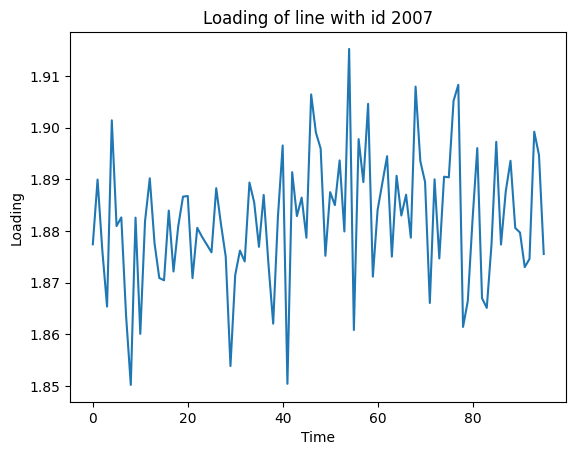

In [17]:
from matplotlib import pyplot as plt

# Prepare data to be plotted. We wish to plot the loading of line with id 4 vs time.
line_4_idx = np.where(output_data[ComponentType.line]["id"] == 4)
result_loading = output_data[ComponentType.line]["loading"][line_4_idx]

plt.plot(result_loading)
plt.title('Loading of line with id 2007')
plt.xlabel('Time')
plt.ylabel('Loading')
plt.show()